In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': 'google-drive id'})

In [0]:
download.GetContentFile('face_train.zip')
!unzip face_train.zip

Archive:  face_train.zip
   creating: image_data/
  inflating: image_data/10001.jpg    
  inflating: image_data/10002.jpg    
  inflating: image_data/10003.jpg    
  inflating: image_data/10004.jpg    
  inflating: image_data/10005.jpg    
  inflating: image_data/10006.jpg    
  inflating: image_data/10007.jpg    
  inflating: image_data/10008.jpg    
  inflating: image_data/10009.jpg    
  inflating: image_data/10010.jpg    
  inflating: image_data/10011.jpg    
  inflating: image_data/10012.jpg    
  inflating: image_data/10013.jpg    
  inflating: image_data/10014.jpg    
  inflating: image_data/10015.jpg    
  inflating: image_data/10016.jpg    
  inflating: image_data/10017.jpg    
  inflating: image_data/10018.jpg    
  inflating: image_data/10019.jpg    
  inflating: image_data/10020.jpg    
  inflating: image_data/10021.jpg    
  inflating: image_data/10022.jpg    
  inflating: image_data/10023.jpg    
  inflating: image_data/10024.jpg    
  inflating: image_data/10025.jpg    


In [0]:
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [0]:
train=pd.read_csv('train.csv')
train.head()

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [0]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if plt.imread(image).ndim == 3:
            plt.gray()
        plt.imshow(plt.imread(image))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()
    plt.show()

In [0]:
images = []
for i in range(len(train)):
  images.append('/content/image_data/'+train['Name'][i])

In [0]:
titles =[]
for i in range(len(train)):
  titles.append("Num Of Head Count:"+str(train['HeadCount'][i]))

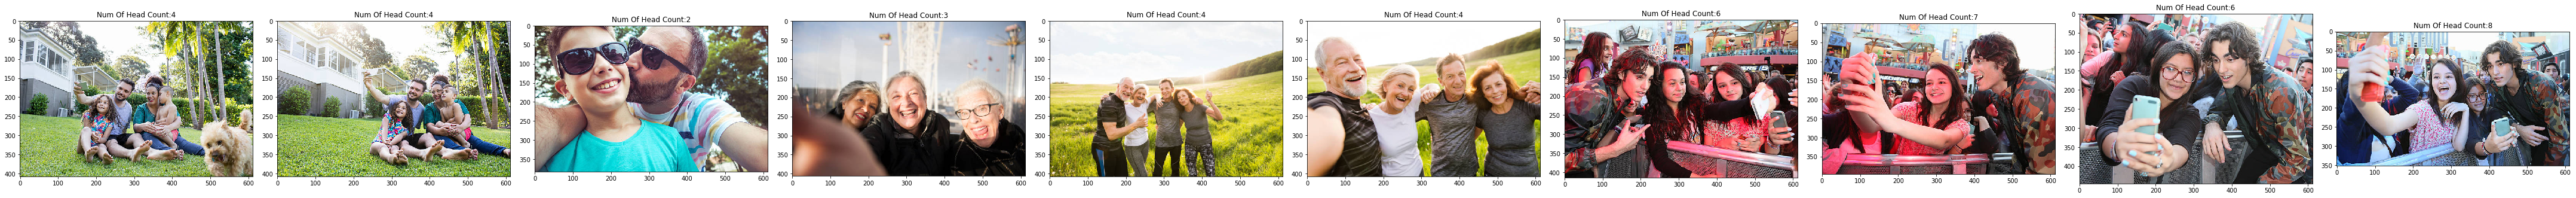

In [0]:
import matplotlib.pyplot as plt
show_images(images[:10],titles=titles[:10])

In [0]:
train_folder="/content/image_data/"

In [0]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
y_train = []
i=0
for _file in train["Name"]:
  train_files.append(train_folder +_file)
    
for count in train["HeadCount"]:
  y_train.append(int(count))
  
print("Files in train_files: %d" % len(train_files))

Files in train_files: 5733


In [0]:
!pip install Pillow

In [0]:
import cv2
x = [] # images as arrays
WIDTH = 299
HEIGHT = 299

for img in train_files:
  full_size_image = cv2.imread(img)
  x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

In [0]:
for i in range(10):
  print(x[i].shape)

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


In [0]:
channels = 3
nb_classes = 1
image_height=299
image_width=299
dataset = np.ndarray(shape=(len(train_files),image_height, image_width,channels),
                     dtype=np.float32)

i = 0
for _file in x:
    a = img_to_array(_file)  
    # Normalize
    a = a / 255.0
    dataset[i] = a
    i += 1

In [0]:
dataset.shape

(5733, 299, 299, 3)

In [0]:
y_label=y_train

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.2, random_state=42)


In [0]:
BATCH_SIZE=32
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(X_train, y_train, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [0]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(X_train, y_train, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [0]:
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))














87916544/87910968 [==============================] - 2s 0us/step


In [0]:
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(1, activation='linear')(out)

In [0]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='mean_squared_error', metrics=['accuracy']) 

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
batch_size = BATCH_SIZE
train_steps_per_epoch = X_train.shape[0] // batch_size
val_steps_per_epoch = X_test.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              verbose=1)

Epoch 1/15
143/143 [==============================] - 905s 6s/step - loss: 5.8987 - acc: 0.2103 - val_loss: 12.1630 - val_acc: 0.1732
Epoch 2/15
143/143 [==============================] - 923s 6s/step - loss: 4.5810 - acc: 0.2637 - val_loss: 12.8059 - val_acc: 0.1866
Epoch 3/15
143/143 [==============================] - 925s 6s/step - loss: 4.3375 - acc: 0.2539 - val_loss: 11.7440 - val_acc: 0.1920
Epoch 4/15
143/143 [==============================] - 892s 6s/step - loss: 3.8645 - acc: 0.2752 - val_loss: 9.0096 - val_acc: 0.1830
Epoch 5/15
143/143 [==============================] - 918s 6s/step - loss: 3.9204 - acc: 0.2789 - val_loss: 8.2015 - val_acc: 0.2495
Epoch 6/15
143/143 [==============================] - 953s 7s/step - loss: 3.5507 - acc: 0.2838 - val_loss: 9.2396 - val_acc: 0.1830
Epoch 7/15
143/143 [==============================] - 906s 6s/step - loss: 3.7474 - acc: 0.2723 - val_loss: 9.8098 - val_acc: 0.2321
Epoch 8/15
143/143 [==============================] - 900s 6s/step

In [0]:
model.save('face_count.hdf5')

In [0]:
test_predictions = model.predict(X_test)
test_predictions

array([[5.6857805],
       [5.7685585],
       [6.233804 ],
       ...,
       [3.91857  ],
       [7.8222275],
       [7.4048796]], dtype=float32)

In [0]:
download = drive.CreateFile({'id': 'googledriveid'})

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
test_data=pd.read_csv("test_Rj9YEaI.csv")

In [0]:
test_data.head(5)

,Name
0,10005.jpg
1,10009.jpg
2,10015.jpg
3,10022.jpg
4,10023.jpg


In [0]:
test_files = []
for _file in test_data["Name"]:
  test_files.append(train_folder +_file)

In [0]:
len(test_files)

2463

In [0]:
import cv2
x = [] # images as arrays
WIDTH = 299
HEIGHT = 299

for img in test_files:
  full_size_image = cv2.imread(img)
  x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

In [0]:
len(x)

2463

In [0]:
channels = 3
nb_classes = 1
image_height=299
image_width=299
testset1 = np.ndarray(shape=(len(test_files),image_height, image_width,channels),
                     dtype=np.float32)

i = 0
for _file in x:
    a = img_to_array(_file)  
    # Normalize
    a = a / 255.0
    testset1[i] = a
    i += 1

In [0]:
testset1.shape

(2463, 299, 299, 3)

In [0]:
y_pred=model.predict(testset1)

In [0]:
y_pred

array([[5.009096 ],
       [7.746709 ],
       [5.5477905],
       ...,
       [6.3789005],
       [8.73769  ],
       [7.609586 ]], dtype=float32)

In [0]:
len(y_pred)

2463

In [0]:
test_data["HeadCount"]=y_pred

In [0]:
test_data.head(5)

,Name,HeadCount
0,10005.jpg,5.009096
1,10009.jpg,7.746709
2,10015.jpg,5.547791
3,10022.jpg,5.636560
4,10023.jpg,7.629600


In [0]:
test_data.to_csv("test_face.csv",index=False)